In [67]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [70]:
BATCH_SIZE = 32 #number of images in a batch
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [71]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './2specplants',  # path to my datset (I used a subset of dataset for training and testing)
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4627 files belonging to 5 classes.


In [72]:
#Different classes in dataset
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

In [74]:
#number of classes
n_classes = len(class_names)
n_classes

5

In [75]:
for image_batch, labels_batch in dataset.take(1): #taking 1 item from dataset
    print(image_batch.shape) # shows batch size, image dimension and channel(3 is for rgb)
    print(labels_batch.numpy()) #labels corresponding to 32 images in the set

(32, 256, 256, 3)
[3 0 0 1 1 0 3 0 2 1 0 3 2 2 2 1 0 1 0 2 0 3 2 3 0 0 2 1 0 1 3 3]


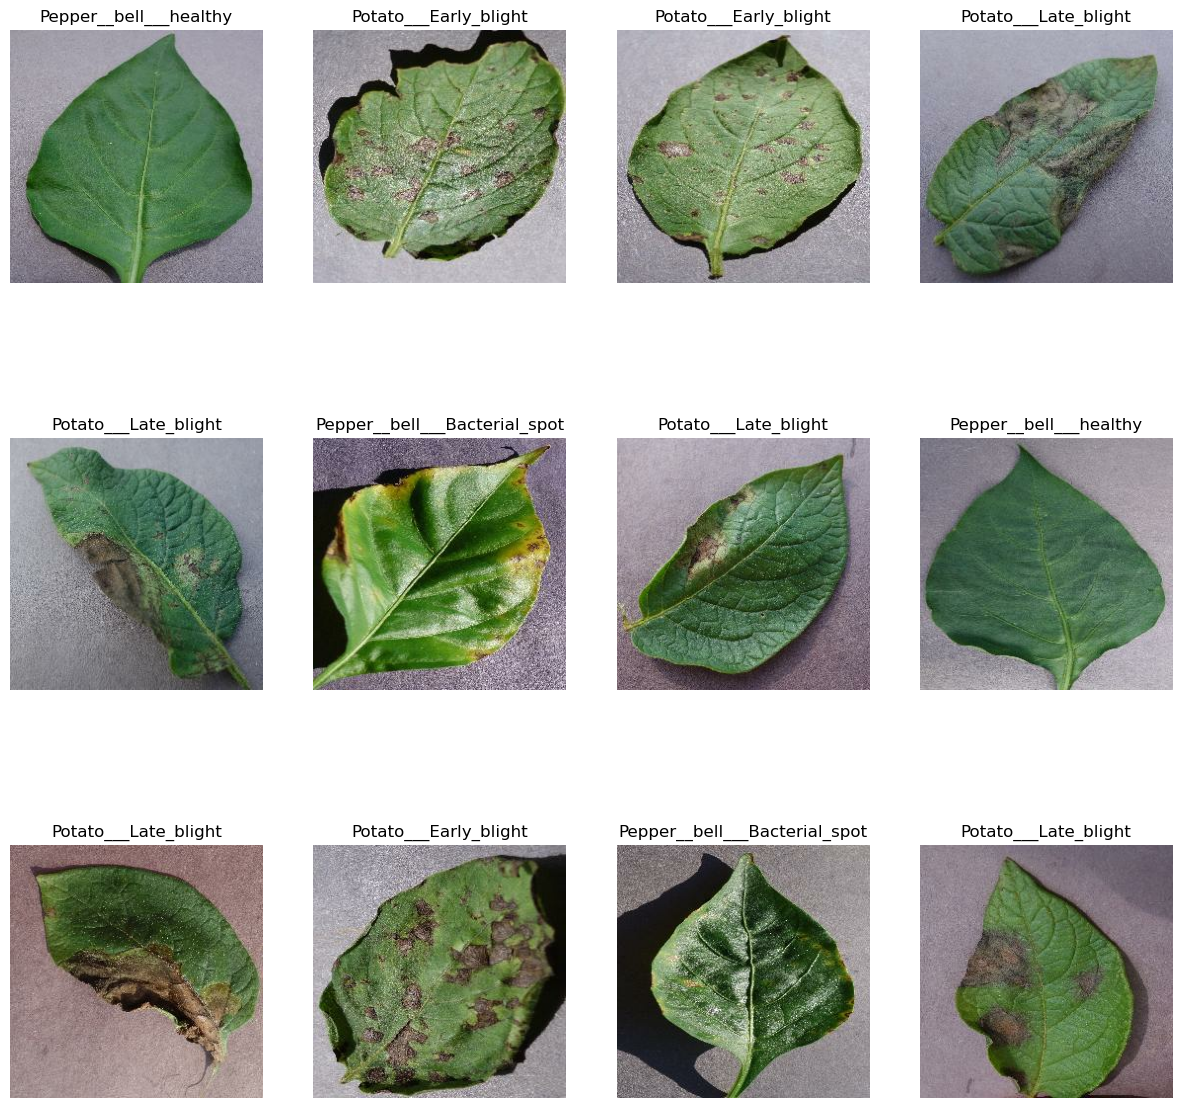

In [76]:
# vizualization of dataset
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [77]:
len(dataset)

145

In [78]:
#function to get train, test and validation data
# train size = 70% , validation size = 20% and testing size = 10%
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [79]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [80]:
len(train_ds)

101

In [81]:
len(val_ds)

29

In [82]:
len(test_ds)

15

In [83]:
#performing cache and prefetch operations
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [84]:
#resizing the data for getting better accuracy
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [85]:
#data augmentation
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [86]:
#Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [87]:
BATCH_SIZE = 32 #number of images in a batch
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [88]:
#CNN architechture
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, (3, 3), activation='relu'),
#     layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'), #dense layer
    layers.Dense(n_classes, activation='softmax'), #normalize the probability of ur classes
])

model.build(input_shape=input_shape)

In [89]:
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_10 (Sequential)           │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (32, 57600)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (32, 64)                    │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (32, 5)                     │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,743,109 (14.28 MB)

 Trainable params: 3,743,109 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

In [90]:
#compiling the model using adam optimizer and loss function used is log loss funnction, metrics is accuracy
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [91]:
#train the network
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS, # for better accuracy pick a higher number
)

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.3801 - loss: 1.7257 - val_accuracy: 0.6557 - val_loss: 0.9092
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 89s 860ms/step - accuracy: 0.7329 - loss: 0.7342 - val_accuracy: 0.7464 - val_loss: 0.6974
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 84s 821ms/step - accuracy: 0.7997 - loss: 0.5299 - val_accuracy: 0.7672 - val_loss: 0.7717
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 84s 822ms/step - accuracy: 0.8610 - loss: 0.3787 - val_accuracy: 0.7847 - val_loss: 0.8449
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 92s 903ms/step - accuracy: 0.8963 - loss: 0.2858 - val_accuracy: 0.8328 - val_loss: 0.6003
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.9001 - loss: 0.2890 - val_accuracy: 0.8383 - val_loss: 0.5537
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9262 - loss: 0.2155 - val_accuracy: 0.8503 - val_loss: 0.5201
Epoch 8/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 100s 986ms/step - accuracy: 0.9204 - loss: 0.2503

In [92]:
scores = model.evaluate(test_ds)

15/15 ━━━━━━━━━━━━━━━━━━━━ 20s 295ms/step - accuracy: 0.9539 - loss: 0.1494


In [93]:
scores #loss,accuracy

[0.19838659465312958, 0.9437500238418579]

In [94]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 101}

In [95]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [96]:
len(history.history['loss'])

20

In [97]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

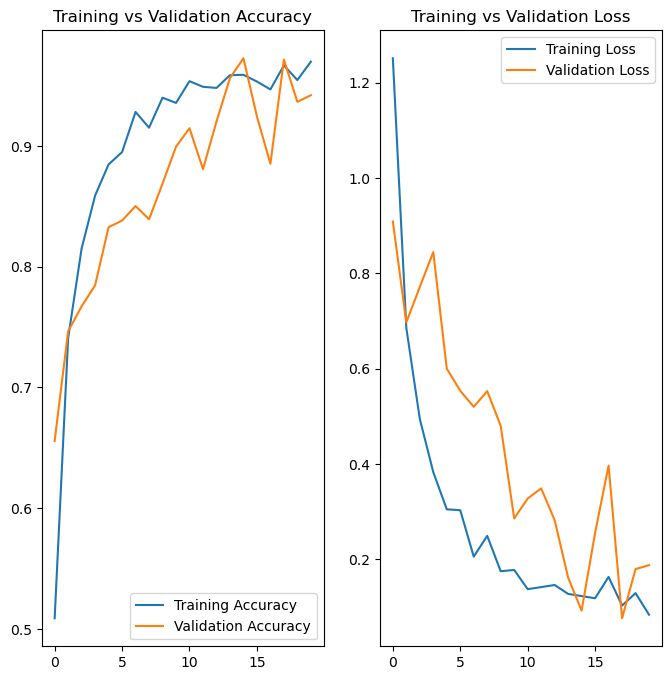

In [98]:
#Plotting graphs b/w training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

#Plotting graphs b/w training and validation loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step
predicted label: Potato___Late_blight


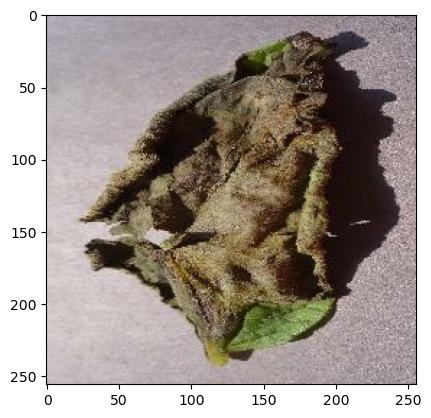

In [99]:
#Testing model on a sample image
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

first image to predict
actual label: Pepper__bell___Bacterial_spot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
predicted label: Pepper__bell___Bacterial_spot


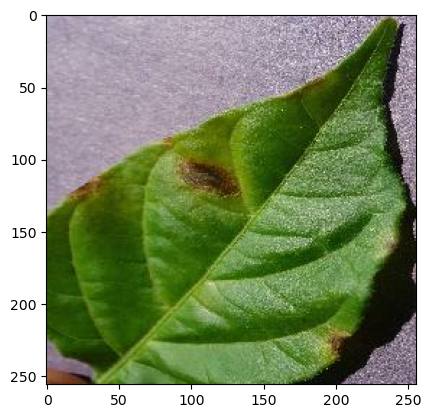

In [100]:
#sample image 2
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [102]:
#creating a predict function for testing on sample inputs
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2) #confidence level calculation
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


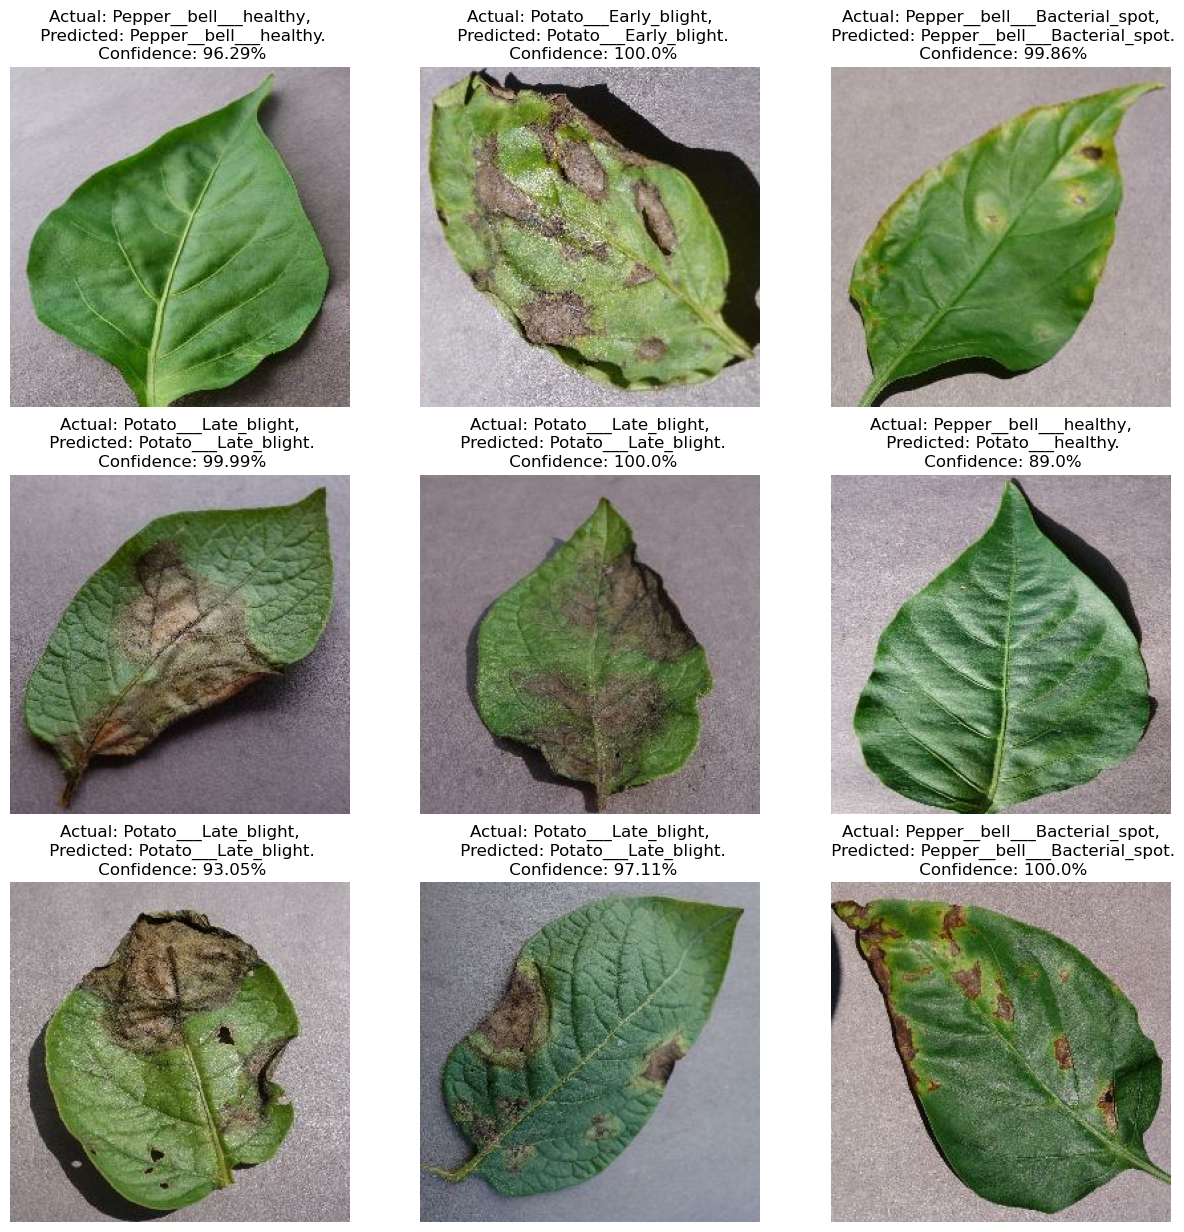

In [103]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")